In [1]:
import os, sys
currentdir = os.path.dirname(os.path.realpath(os.path.abspath("")))
scriptsdir = os.path.dirname(currentdir)
if scriptsdir not in sys.path:
    sys.path.append(scriptsdir)

from customscripts import configuration
from customscripts import utils

# Common imports
import numpy as np
import scipy as sp
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from scipy import stats
from matplotlib import cm
from sklearn.cluster import KMeans

formatter = ticker.FuncFormatter(utils.human_format)

So the data in this week have basically the structure as following:

Food
 - 1: Fruits and Vegetables
 - 2: Meat and Seafood
 - 3: Grains and Cereals
 - 4: Beverages
 - 5: Dairy

Industrial Product
 - 6: Minerals
 - 7: Base Metals
 - 8: Chemicals and Plastics
 - 9: Guns

In [2]:
# # get_dataset_df(weekNumber, datasetFileName)
# data = utils.get_dataset_df(4, "nutrition_unicef_cleaned")

# # first is the food data 
# data_food = utils.get_dataset_df(3, "all_categories") \
#     .drop(columns=['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'Unnamed: 0.1.1.1', 'Classification', 'Trade Flow Code', 'Reporter Code', \
#  'Reporter', 'Partner Code', 'Partner', 'Qty', 'Qty Unit', 'Qty Unit Code', 'Netweight (kg)', 'Category Code', 'Development Category', '% Malnutritioned Childern < 5 years old'])

# data_food = data_food.loc[data_food['Year'] >= 2007]
# data_food = data_food.loc[data_food['Trade Flow'] == 'Import']
# data_food['Year'] = data_food['Year'].astype(str)

# # then is the data of industrial product
data_industrial = utils.get_dataset_df(4, "final") \
    .drop(columns=['Unnamed: 0', 'Unnamed: 0.1', 'Classification', 'Trade Flow Code', 'Reporter Code', \
 'Reporter', 'Partner Code', 'Partner', 'Development Category']) 
data_industrial = data_industrial.dropna(subset=['Year'])
# remove the decimals in the column 'Year'
data_industrial['Year'] = data_industrial['Year'].astype(int).astype(str)


GDP_growth_data = data_industrial.drop(columns = ['Year', 'Trade Flow', 'Partner ISO', 'Commodity Code', 'Commodity', \
    'Trade Value (US$)', 'Category Code', 'Category', 'Development Level', 'Population in 2005 (in million)', \
    'Population in 2010 (in million)', 'Population in 2014 (in million)', 'Population in 2018 (in million)']).drop_duplicates()

So the month data contains the time interval of 11 years, from 2009-01 to 2019-12, with all data being imported trade value and also abort the category "Guns"

In [3]:
import zipfile

population_zip = zipfile.ZipFile(scriptsdir +'\dataset\week4.zip', 'r')
population_csv =population_zip.open('week4/population.csv')
data_population = pd.read_csv(population_csv).drop(columns=['Unnamed: 65', '2020'])

# month_zip = zipfile.ZipFile(scriptsdir +'\\dataset\\week6.zip', 'r')
# month_csv = month_zip.open('week6/all_misc_data.csv')
# # apply: data_misc["Time"] = pd.to_datetime(data_misc["Time"], format="%Y-%m-%d")
# data_month = pd.read_csv(month_csv).drop(columns=['Unnamed: 0'])

In [4]:
data_cate_year = data_industrial.loc[(data_industrial['Category'] == 'Base Metals') & (data_industrial['Trade Flow'] == 'Import')]
# First add the Trade Value per Capita to the same data frame
# Initialization
data_cate_year['Trade Value per capita'] = data_cate_year['Year']

year_sequence = sorted(data_cate_year['Year'].unique().tolist())
reporters_sequence = sorted(data_cate_year['Reporter ISO'].unique().tolist())

# implement the trade value per capita
for _, reporter in enumerate(reporters_sequence):
    # print(reporter) # for debugging
    for count, year in enumerate(year_sequence):
        data_cate_year['Trade Value per capita'] = data_cate_year['Trade Value per capita'] \
            .mask( (data_cate_year['Reporter ISO'] == reporter) & (data_cate_year['Year'] == year) , \
                data_cate_year['Trade Value (US$)'] / data_population.loc[data_population['Country Code'] == reporter][year].values )


In [5]:
# get the trade value for 15 different reporters in 13 years
data_cate_year = data_cate_year.groupby(['Year', 'Reporter ISO']) \
    .agg(Trade_Value_per_Capita=('Trade Value per capita', "sum")) \
    .reset_index() \
    .sort_values(by=['Reporter ISO', 'Year'], ascending=True)

# Now add the Population, GDP growth to the same data frame
# Initialization
data_cate_year['Population'] = data_cate_year['Year']
data_cate_year['GDP Growth'] = data_cate_year['Year']

for _, year in enumerate(year_sequence):
    for _, reporter in enumerate(reporters_sequence):
        data_cate_year['GDP Growth'] = data_cate_year['GDP Growth'] \
            .mask( (data_cate_year['Reporter ISO'] == reporter) & (data_cate_year['Year'] == year) , \
                GDP_growth_data.loc[GDP_growth_data['Reporter ISO'] == reporter]["GDP Growth % in " + year].values )
        
        data_cate_year['Population'] = data_cate_year['Population'] \
            .mask( (data_cate_year['Reporter ISO'] == reporter) & (data_cate_year['Year'] == year) , \
                data_population.loc[data_population['Country Code'] == reporter][year].values )        

In [6]:
data_cate_year['Value Change'] = data_cate_year['Trade_Value_per_Capita'].pct_change()
data_cate_year['Population Change'] = data_cate_year['Population'].pct_change()
# drop the data in 2007 since the pct change is nan
# so in the end only have data form 2008 to 2019, so 12*15=180 points for clustering
# data_cate_year = data_cate_year.loc[data_cate_year['Year'].isin(year_sequence[1:])]
data_cate_year['Log Trade Value per Capita'] = np.log(data_cate_year['Trade_Value_per_Capita'])

## Countries' development level clustering


In [7]:
plot_data = data_cate_year.loc[data_cate_year['Year'].isin(year_sequence[1:])]

# abondon the value in EGY since it's somehow like outliers
plot_data = plot_data[plot_data['Value Change'] < 1]

# need to apply normalization to the two series first
plot_data['Value Change'] = ( plot_data['Value Change'] - plot_data['Value Change'].min() ) \
     / (plot_data['Value Change'].max() - plot_data['Value Change'].min())

plot_data['Population Change'] = ( plot_data['Population Change'] - plot_data['Population Change'].min() ) \
     / (plot_data['Population Change'].max() - plot_data['Population Change'].min())

plot_data['GDP Growth'] = ( plot_data['GDP Growth'] - plot_data['GDP Growth'].min() ) \
     / (plot_data['GDP Growth'].max() - plot_data['GDP Growth'].min())

plot_data['Log Trade Value per Capita'] = ( plot_data['Log Trade Value per Capita'] - plot_data['Log Trade Value per Capita'].min() ) \
     / (plot_data['Log Trade Value per Capita'].max() - plot_data['Log Trade Value per Capita'].min())

# at last abondon the population growth value which is likely to be some outliers
plot_data = plot_data[plot_data['Population Change'] > 0]

In [9]:
# # # cannot rotate here in the VS code
# # # better use notebook for visualization and then uncomment these two lines
# # # even with 3D plot, we can not see a very clear cluster
# %matplotlib notebook

# # %matplotlib inline
# from matplotlib import animation
# from mpl_toolkits.mplot3d import Axes3D

# fig = plt.figure();
# ax = fig.add_subplot(111, projection='3d');

# m = ['o', 'x', '^']
# c = ['r', 'g', 'b']
# def init():
#     for count, level in enumerate(developed_level):
#         xs = plot_data.loc[plot_data['Reporter ISO'].isin(level)]['Population Change'];
#         ys = plot_data.loc[plot_data['Reporter ISO'].isin(level)]['Log Trade Value per Capita'];
#         zs = plot_data.loc[plot_data['Reporter ISO'].isin(level)]['GDP Growth'];
#         ax.scatter(xs, ys, zs, marker=m[count], color=c[count]);
#     return fig,

# ax.set_xlabel('Population Change');
# ax.set_ylabel('Log Trade Value per Capita');
# ax.set_zlabel('GDP Growth');

# def animate(i):
#     ax.view_init(elev=10., azim=i)
#     return fig,

# # Animate
# anim = animation.FuncAnimation(fig, animate, init_func=init, frames=360, interval=20, blit=True)
# # Save
# anim.save('basic_animation.mp4', fps=30, extra_args=['-vcodec', 'libx264'])

Nondeterministic machine learning algorithms like k-means are difficult to reproduce. The random_state parameter is set to an integer value so you can follow the data presented in the tutorial. In practice, it’s best to leave random_state as the default value, None.

In [8]:
# here I exclude some countries in different developed levels
high_developed = ['DEU', 'HKG', 'JPN', 'KOR', 'USA'] # with HKG excluded since there is no record in this dataset
medium_developed = ['BRA', 'CHN', 'MEX', 'THA', 'TUR'] # no CHN dataset
low_developed = ['EGY', 'NGA', 'PAK', 'NGA', 'VNM'] # with IND, VNM excluded, same reason
developed_level = [high_developed, medium_developed, low_developed]

In [9]:
def plot_clusters(data, dim_1, dim_2):
    
    fig, ax = plt.subplots(1, 3, figsize=(18, 4))
    
    wcss = [];
    for i in range(1, 11):
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0);
        kmeans.fit( data[[dim_1, dim_2]] );
        wcss.append(kmeans.inertia_);
    ax[0].plot(range(1, 11), wcss);
    ax[0].set_title('Elbow Method');
    ax[0].set_xlabel('Number of clusters');
    ax[0].set_ylabel('WCSS');

    kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=0);
    pred_y = kmeans.fit_predict(data[[dim_1, dim_2]]);
    ax[1].scatter(x=data[dim_1], y=data[dim_2])
    ax[1].scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red');
    ax[1].set_title('Possible cluster for ' + dim_1 + ' and ' + dim_2);
    ax[1].set_xlabel(dim_1)
    ax[1].set_ylabel(dim_2)

    # for _, reporter in enumerate(reporters_sequence):
        # ax.scatter(x=data.loc[data['Reporter ISO']== reporter][dim_1], y=data.loc[data['Reporter ISO']== reporter][dim_2], cmap=cm.winter);
    ax[2].scatter(x=data.loc[data['Reporter ISO'].isin(high_developed)][dim_1], y=data.loc[data['Reporter ISO'].isin(high_developed)][dim_2], color='r');
    ax[2].scatter(x=data.loc[data['Reporter ISO'].isin(medium_developed)][dim_1], y=data.loc[data['Reporter ISO'].isin(medium_developed)][dim_2], color='g');
    ax[2].scatter(x=data.loc[data['Reporter ISO'].isin(low_developed)][dim_1], y=data.loc[data['Reporter ISO'].isin(low_developed)][dim_2], color='b');
    ax[2].set_title("Ground truth for each cluster")
    ax[2].set_xlabel(dim_1)
    ax[2].set_ylabel(dim_2)

We graph the relationship between the number of clusters and Within Cluster Sum of Squares (WCSS) then we select the number of clusters where the change in WCSS begins to level off (elbow method). You can compute WCSS as the sum of the squared distance between each member of the cluster and its centroid. But actually the clustering here is a bit tidious, since we already know that there only exist 3 developed levels?

Next, we’ll categorize the data using the optimum number of clusters 3 we determined in the last step. Using the initial method "k-means++" here ensures that you get don’t fall into the random initialization trap.

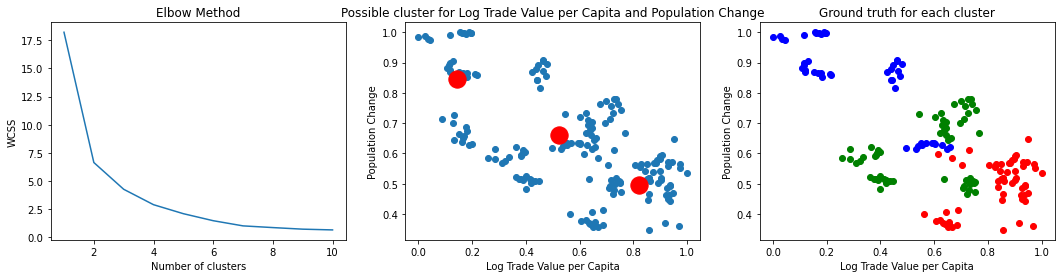

In [16]:
# Value Change w.r.t. GDP Growth, these two dimensions seem not friendly for clustering
# So instead we focus on the population change w.r.t. the economic factors
plot_clusters(plot_data, 'Log Trade Value per Capita', 'Population Change')

In [27]:
def plot_reporter_clusters(data, dim_1, dim_2):
    
    colours = cm.prism(np.linspace(0, 1, 15));
    fig, ax = plt.subplots();
    for _, reporter in enumerate(reporters_sequence):
        ax.scatter(x=data.loc[data['Reporter ISO']== reporter][dim_1], y=data.loc[data['Reporter ISO']== reporter][dim_2], cmap=cm.winter);
    ax.set_title("Ground truth for each reporter")
    ax.set_xlabel(dim_1)
    ax.set_ylabel(dim_2)

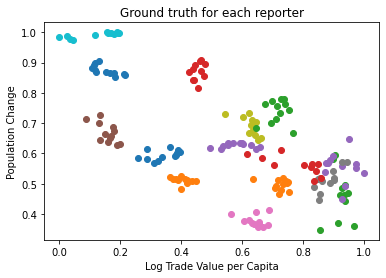

In [28]:
plot_reporter_clusters(plot_data, 'Log Trade Value per Capita', 'Population Change')


What about use DBSCAN to find the corresponding clusters?

In [49]:
labels_true = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, \
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, \
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, \
    2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, \
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, \
    2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, \
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, \
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, \
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, \
    2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, \
    2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, \
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, \
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, \
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, \
    2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, \
    ]   

array(['BRA', 'CHN', 'DEU', 'EGY', 'HKG', 'IND', 'JPN', 'KOR', 'MEX',
       'NGA', 'PAK', 'THA', 'TUR', 'USA', 'VNM'], dtype=object)

In [46]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

centers = [[1, 1], [-1, -1], [1, -1]]
X, labels_true = make_blobs(n_samples=750, centers=centers, cluster_std=0.4,
                            random_state=0)

X = StandardScaler().fit_transform(X)

Estimated number of clusters: 1
Estimated number of noise points: 0


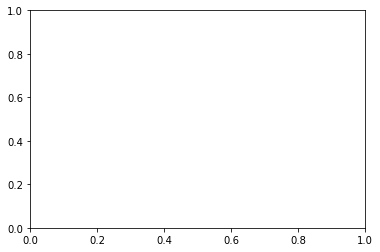

In [43]:
fig, ax  = plt.subplots()

db = DBSCAN(eps=0.15, min_samples=5).fit(plot_data[['Log Trade Value per Capita', 'Population Change']])
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
# # Black removed and is used for noise instead.
# unique_labels = set(labels)
# colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
# for k, col in zip(unique_labels, colors):
#     if k == -1:
#         # Black used for noise.
#         col = [0, 0, 0, 1]

#     class_member_mask = (labels == k)

#     xy = plot_data[class_member_mask & core_samples_mask]
#     plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
#              markeredgecolor='k', markersize=14)

#     xy = X[class_member_mask & ~core_samples_mask]
#     plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
#              markeredgecolor='k', markersize=6)

# plt.title('Estimated number of clusters: %d' % n_clusters_)
# plt.show()

# ax.scatter(x=plot_data['Log Trade Value per Capita'], y=plot_data['Population Change'])
# ax.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red');
# ax.set_title('Possible cluster for Log Trade Value per Capita Population Change');
# ax.set_xlabel('Log Trade Value per Capita')
# ax.set_ylabel('Population Change')